In [2]:
# imports

from obspy import UTCDateTime
import numpy as np
from obspy.clients.fdsn import Client
from obspy import Stream
from obspy.signal.util import next_pow_2
from obspy.geodetics import gps2dist_azimuth
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# set up

# Example  (Hawaii HV, 2018):
CENTER_LAT, CENTER_LON = 19.3, -155.5
STARTTIME = "2014-05-01T00:00:00"
ENDTIME   = "2016-12-31T23:59:59"

# Search radius (degrees) for HV stations around the center:
MAXRADIUS_DEG = 10.0

# Prefer inter-station distances in this range (km) for microseism band:
MIN_DIST_KM, MAX_DIST_KM = 100.0, 400.0

# Band of interest (volcano):
FREQMIN = 0.5   # Hz  (20 s)
FREQMAX = 10.0   # Hz  (5 s)

# Windowing and correlation
WINDOW_LENGTH = 24 * 3600     # seconds (one-day windows)
DEFAULT_MAX_LAG = 300         # seconds; will auto-bump based on pair distance
TIME_NORMALIZATION = "onebit" # "onebit", "ram", or None
RAM_WINDOW_SEC = 10

# Response removal (to velocity)
# PRE_FILT = (0.005, 0.006, 45.0, 50.0)
# WATER_LEVEL = 60

# creates a client that connects to the IRIS data center
client = Client("IRIS")


In [4]:
# fetch data
def fetch_stream(net, sta, loc, cha, t0, t1, client_name="IRIS", attach_resp=True):
    client = Client(client_name)
    st = client.get_waveforms(net, sta, loc, cha, t0, t1, attach_response = attach_resp)
    st.merge(fill_value="interpolate")
    return st

In [5]:
# pre-process
def basic_preprocess(st, freqmin, freqmax):
    st = st.copy()
    st.detrend("linear")
    st.detrend("demean")
    st.taper(max(10.0 / st[0].stats.sampling_rate, 0.05))
    st.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)
    return st

# visualize pre-processing
def viz_detrend(st, method):
    processed = st.detrend(method)

    return processed

Demean removes a constant offset (non-zero average) from the time series.

Detrend removes a linear ramp (often caused by instrument drift, timing issues, or long-period noise).

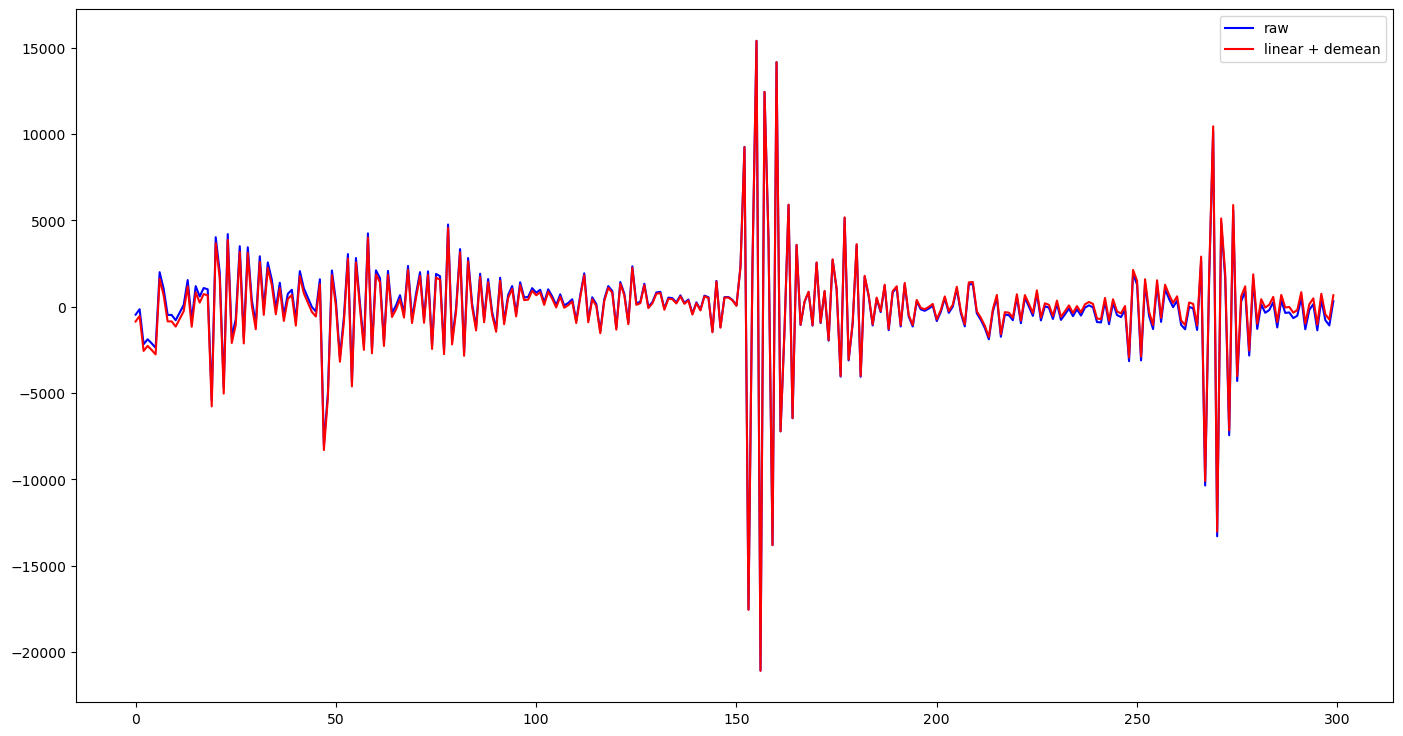

In [9]:
# Input station informations

freqmin = 0.5   # Hz  (20 s)
freqmax = 10.0   # Hz  (5 s)

stt = UTCDateTime("2014-10-01T03:35:40")
edt = UTCDateTime("2014-10-01T03:35:43")

# network
net = 'XD'
# station
sta = 'ME02'
# location
loc = '*'
# channel
cha = 'HHZ'

# Get the waveforms from client
st = client.get_waveforms(net, sta, loc, cha, stt, edt)
copy_st = st.copy()

method = "linear"
st_process = viz_detrend(copy_st, method)

copy_st2 = st.copy()
method2 = "demean"
st_process2 = viz_detrend(copy_st2, method2)

st_process3 = copy_st.detrend("linear")
st_process3.detrend("demean")


plt.figure(figsize=(17,9))

# raw
for tr in st:
    data1 = tr.data
plt.plot(data1,color='blue',label='raw')

# linear + mean
for tr in st_process3:
    data4 = tr.data
plt.plot(data4,color='red',label="linear + demean")

plt.legend()


taper smoothes the edges

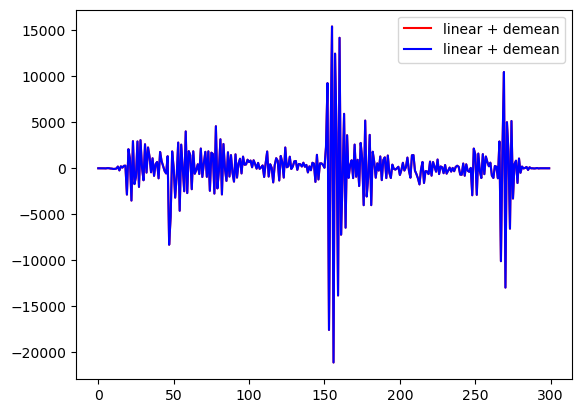

In [11]:
st_process3.taper(max(10.0 / st[0].stats.sampling_rate, 0.05))

for tr in st_process3:
    data5 = tr.data
plt.plot(data5,color='blue',label="linear + demean")

plt.legend()

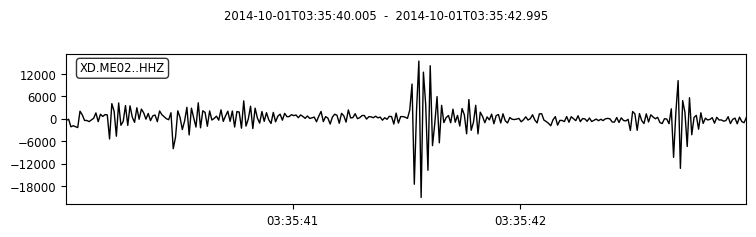

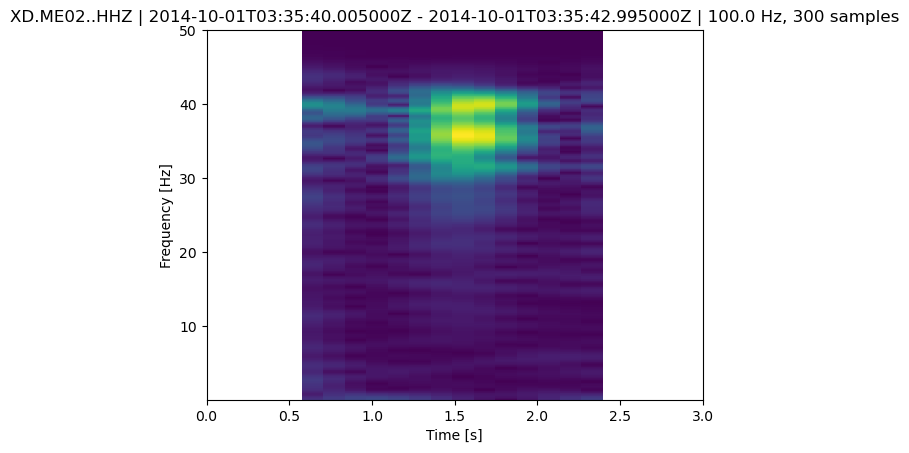

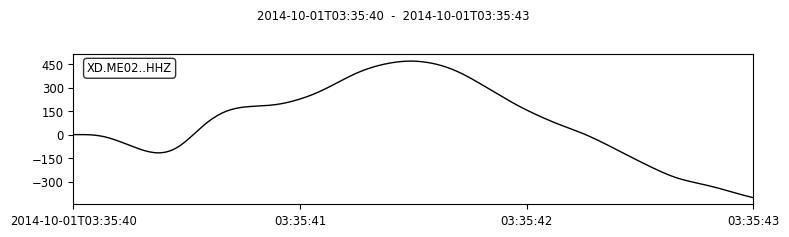

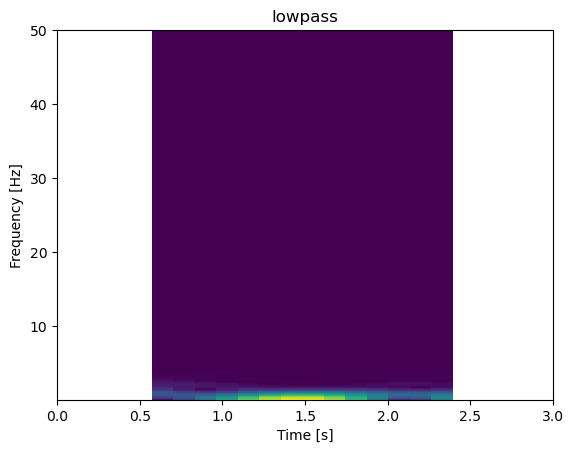

[None]

In [16]:
st.plot()
st.spectrogram()

processed_low = st.copy()
processed_low.filter("lowpass",freq=1)
processed_low.plot(starttime=stt,endtime=edt)
processed_low.spectrogram(title='lowpass')

# st_process3.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)